## Notebook for visualizing chemical space in reduced dimensions

**Created on 28th Feb; modified on 9th March, 2023; remodified on 18th February, 2024**

In [5]:
import os, sys
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import umap
# import hdbscan
# import molplotly

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
import plotly.express as px
from IPython.display import SVG, display
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [5]:
# cmap = mcolors.LinearSegmentedColormap.from_list('', [(vmin, 'white'), (vmax, color)])
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
def create_cmap(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

**t-SNE plot for revision**

In [3]:
df = pd.read_csv('./unique_solvent_databases_fgrp_class.csv')
df

,smiles,mean_property_value,database,class
0,C(C#CC(C)C)(C)C,5.481535,MP_oxstab,Other
1,C(=O)=O,9.433272,MP_oxstab,Other
2,O,7.902121,MP_oxstab,Other
3,C(=C\C)/C(C)C,5.085723,MP_oxstab,Other
4,c1(c(ccc(c1)C)C)C,4.733493,MP_oxstab,Aromatic
...,...,...,...,...
18383,O=C1OCC(F)O1,0.977029,EDB_2,Carbonate
18384,O=C1OCCO1,0.909369,EDB_2,Carbonate
18385,O=C=O,0.999000,EDB_2,Other
18386,O=S1(=O)CCCC1,0.985000,EDB_2,Sulfone


In [4]:
trial = 2 ## best trial from tSNE optimization
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['tsne_0'] = X_tsne[:,0]
df['tsne_1'] = X_tsne[:,1]
df

,smiles,mean_property_value,database,class,tsne_0,tsne_1
0,C(C#CC(C)C)(C)C,5.481535,MP_oxstab,Other,-6.410224,13.813857
1,C(=O)=O,9.433272,MP_oxstab,Other,-7.769682,11.576021
2,O,7.902121,MP_oxstab,Other,-7.911518,11.967489
3,C(=C\C)/C(C)C,5.085723,MP_oxstab,Other,-6.198877,13.288918
4,c1(c(ccc(c1)C)C)C,4.733493,MP_oxstab,Aromatic,-8.717965,-2.809125
...,...,...,...,...,...,...
18383,O=C1OCC(F)O1,0.977029,EDB_2,Carbonate,-16.734008,12.081770
18384,O=C1OCCO1,0.909369,EDB_2,Carbonate,-14.556107,11.989193
18385,O=C=O,0.999000,EDB_2,Other,-7.769577,11.575893
18386,O=S1(=O)CCCC1,0.985000,EDB_2,Sulfone,-12.839743,15.308449


In [7]:
mp_os = df.loc[df['database'] == 'MP_oxstab']
edb_cond = df.loc[df['database'] == 'EDB_1']
edb_ce = df.loc[df['database'] == 'EDB_2']
mp_os

,smiles,mean_property_value,database,class,tsne_0,tsne_1
0,C(C#CC(C)C)(C)C,5.481535,MP_oxstab,Other,-6.410224,13.813857
1,C(=O)=O,9.433272,MP_oxstab,Other,-7.769682,11.576021
2,O,7.902121,MP_oxstab,Other,-7.911518,11.967489
3,C(=C\C)/C(C)C,5.085723,MP_oxstab,Other,-6.198877,13.288918
4,c1(c(ccc(c1)C)C)C,4.733493,MP_oxstab,Aromatic,-8.717965,-2.809125
...,...,...,...,...,...,...
18128,c1cc(c2c(c1)[nH]sn2N(=O)=O)C(=O)O,3.220508,MP_oxstab,Aromatic,10.546230,-37.854230
18129,CC(=O)c1ccc2c(c1C#N)[nH]s[nH]2,3.620069,MP_oxstab,Aromatic,35.826346,-35.354644
18130,CCn1c2ccc(cc2[nH]s1)Cl,3.308856,MP_oxstab,Aromatic,17.869811,-37.910489
18131,CCc1ccc2c(c1O)[nH]s[nH]2,3.476727,MP_oxstab,Aromatic,35.352413,-36.672439


In [20]:
print(df['tsne_0'].min(), df['tsne_0'].max())
print(df['tsne_1'].min(), df['tsne_1'].max())

-44.60833425442746 46.798312998047635
-76.54496220410645 76.36872767521616


In [8]:
def create_cmap(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


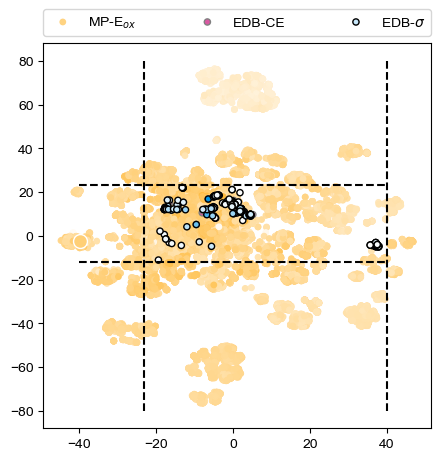

In [80]:
fig, ax = plt.subplots(figsize=(5,5))
# cmap1, norm1 = create_cmap(mp_ie["mean_prop"], (0.984, 0.713, 0.305))  ## orange colormap
cmap1, norm1 = create_cmap(mp_os["mean_property_value"], 'orange')  ## orange colormap --> Oxstab
cmap2, norm2 = create_cmap(edb_cond["mean_property_value"], (0, 0.576, 0.902))  ## blue colormap --> Conductivity
cmap3, norm3 = create_cmap(edb_ce["mean_property_value"], (0.839, 0.286, 0.604))  ## purple colormap --> CE

# Define the coordinates of the points you want to highlight
highlight_coords = [tuple(row) for row in df.loc[df['smiles'].isin(['c1cc2c(cc1)C(=O)c1c(C2=O)cccc1'])][['tsne_0', 'tsne_1']].values]

mask1 = ~mp_os[['tsne_0', 'tsne_1']].apply(tuple, 1).isin(highlight_coords)
scatter1 = ax.scatter(mp_os[mask1]["tsne_0"], mp_os[mask1]["tsne_1"], c=mp_os[mask1]["mean_property_value"], s=15, cmap=cmap1, norm=norm1, label='MP-E$_{ox}$', edgecolors=None)
mask2 = mp_os[['tsne_0', 'tsne_1']].apply(tuple, 1).isin(highlight_coords)
scatter1_ = ax.scatter(mp_os[mask2]["tsne_0"], mp_os[mask2]["tsne_1"], c=mp_os[mask2]["mean_property_value"], s=100, cmap=cmap1, norm=norm1, edgecolors='white')

# scatter1 = ax.scatter(mp_os["tsne_0"], mp_os["tsne_1"], c=mp_os["mean_property_value"], s=15, cmap=cmap1, norm=norm1, label='MP-E$_{ox}$', edgecolors=None)
scatter3 = ax.scatter(edb_ce["tsne_0"], edb_ce["tsne_1"], c=edb_ce["mean_property_value"], s=20, cmap=cmap3, norm=norm3, label='EDB-CE', edgecolors='grey')
scatter2 = ax.scatter(edb_cond["tsne_0"], edb_cond["tsne_1"], c=edb_cond["mean_property_value"], s=20, cmap=cmap2, norm=norm2, label='EDB-$\sigma$', edgecolors='black')
# plt.xticks(ticks=[-100,-50,0,50,100], labels=[-100,-50,0,50,100])
ax.vlines(x=[-23,40], ymin=-80, ymax=80, linestyles='dashed', colors='black')
ax.hlines(y=[-12,23], xmin=-40, xmax=40, linestyles='dashed', colors='black')

# plt.xlim([-50,50])
# plt.ylim([-80,80])
# fig.colorbar(scatter1, ax=ax, ticks=[2, 4, 6, 8, 10, 11])
# fig.colorbar(scatter2, ax=ax, ticks=[0.9, 4, 8, 12, 16, 20, 24])
# fig.colorbar(scatter3, ax=ax, ticks=[0.6, 0.7, 0.8, 0.9, 0.99])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
# ax.set_aspect(aspect=0.9)

plt.savefig('tsne_fig1f.eps', dpi=300)
# plt.savefig('tsne_fig1f.tiff', dpi=300)

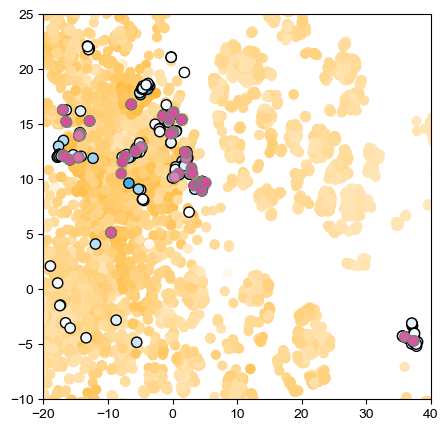

In [59]:
## not used
fig, ax = plt.subplots(figsize=(5,5))
cmap1, norm1 = create_cmap(mp_os["mean_property_value"], 'orange')  ## orange colormap --> Oxstab
cmap2, norm2 = create_cmap(edb_cond["mean_property_value"], (0, 0.576, 0.902))  ## blue colormap --> Conductivity
cmap3, norm3 = create_cmap(edb_ce["mean_property_value"], (0.839, 0.286, 0.604))  ## purple colormap --> CE
scatter1 = ax.scatter(mp_os["tsne_0"], mp_os["tsne_1"], c=mp_os["mean_property_value"], s=40, cmap=cmap1, label='MP-E$_{ox}$')
scatter2 = ax.scatter(edb_cond["tsne_0"], edb_cond["tsne_1"], c=edb_cond["mean_property_value"], s=55, cmap=cmap2, label='EDB-$\sigma$', edgecolors='black')
scatter3 = ax.scatter(edb_ce["tsne_0"], edb_ce["tsne_1"], c=edb_ce["mean_property_value"], s=55, cmap=cmap3, label='EDB-CE', edgecolors='grey')
plt.xlim([-20,40])
plt.ylim([-10,25])
acn_loc = tuple(df.loc[df['smiles'] == 'CC#N'][['tsne_0', 'tsne_1']].values[0])
# plt.annotate('DEG-FTrieG(CE)', xy=(37.343513, 29.121128), color='black', fontsize=10)
# plt.annotate('DME(CE)', xy=(37.313713, 25.352137), color='black', fontsize=10)
# plt.annotate('ACN(Cond)', xy=(-2.291785, 38.299450), color='black', fontsize=10)
# plt.annotate('PC(Cond)', xy=(25.893730, 31.824602), color='black', fontsize=10)
# fig.colorbar(scatter1, ax=ax, ticks=[1, 3, 5, 7, 9, 11])
# fig.colorbar(scatter3, ax=ax, ticks=[0.6, 0.7, 0.8, 0.9, 0.99])
# fig.colorbar(scatter2, ax=ax, ticks=[0.1, 4, 8, 12, 16, 20, 24])
# plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=3)
# plt.yticks(ticks=[-20,-10,0,10,20,30,40,50], labels=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-10,10,30,50])
# ax.yaxis.set_ticks(ticks=[-10,10,30,50])
# ax.set_aspect('equal')
# ax.set_yticks([-20,-10,0,10,20,30,40,50])
# plt.savefig('tsne_mean_threeProp_zoom_051623.eps', dpi=300, bbox_inches='tight')

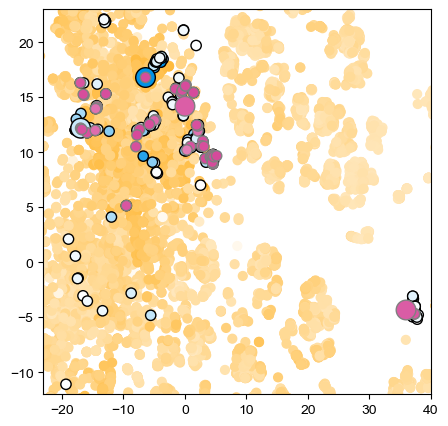

In [74]:
fig, ax = plt.subplots(figsize=(5,5))
cmap1, norm1 = create_cmap(mp_os["mean_property_value"], 'orange')  ## orange colormap --> Oxstab
cmap2, norm2 = create_cmap(edb_cond["mean_property_value"], (0, 0.576, 0.902))  ## blue colormap --> Conductivity
cmap3, norm3 = create_cmap(edb_ce["mean_property_value"], (0.839, 0.286, 0.604))  ## purple colormap --> CE

# Define the coordinates of the points you want to highlight
highlight_coords_1 = [tuple(row) for row in df.loc[df['smiles'].isin(['CC#N', 'CC1COC(=O)O1'])][['tsne_0', 'tsne_1']].values]
highlight_coords_2 = [tuple(row) for row in df.loc[df['smiles'].isin(['COCCOC', 'COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC'])][['tsne_0', 'tsne_1']].values]

scatter1 = ax.scatter(mp_os["tsne_0"], mp_os["tsne_1"], c=mp_os["mean_property_value"], s=40, cmap=cmap1, label='MP-E$_{ox}$')

# Create a mask that is True for all points except the ones at highlight_coords
mask1_1 = ~edb_cond[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter1_1 = ax.scatter(edb_cond[mask1_1]["tsne_0"], edb_cond[mask1_1]["tsne_1"], c=edb_cond[mask1_1]["mean_property_value"], s=55, cmap=cmap2, label='EDB-$\sigma$', edgecolors='black')

# Create a mask that is True only for the points at highlight_coords and plot these points with a different edge color
mask1_2 = edb_cond[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter1_2 = ax.scatter(edb_cond[mask1_2]["tsne_0"], edb_cond[mask1_2]["tsne_1"], c=edb_cond[mask1_2]["mean_property_value"], s=200, cmap=cmap2, label='EDB-$\sigma$', edgecolors='black', vmin=edb_cond["mean_property_value"].min(), vmax=edb_cond["mean_property_value"].max())

mask2_1 = ~edb_ce[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_1 = ax.scatter(edb_ce[mask2_1]["tsne_0"], edb_ce[mask2_1]["tsne_1"], c=edb_ce[mask2_1]["mean_property_value"], s=55, cmap=cmap3, label='EDB-CE', edgecolors='grey')

mask2_2 = edb_ce[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_2 = ax.scatter(edb_ce[mask2_2]["tsne_0"], edb_ce[mask2_2]["tsne_1"], c=edb_ce[mask2_2]["mean_property_value"], s=200, cmap=cmap3, label='EDB-CE', edgecolors='grey', vmin=edb_ce["mean_property_value"].min(), vmax=edb_ce["mean_property_value"].max())
# scatter3 = ax.scatter(edb_ce["tsne_0"], edb_ce["tsne_1"], c=edb_ce["mean_property_value"], s=55, cmap=cmap3, label='EDB-CE', edgecolors='grey')
plt.xlim([-23,40])
plt.ylim([-12,23])
acn_loc = tuple(df.loc[df['smiles'] == 'CC#N'][['tsne_0', 'tsne_1']].values[0])

# plt.yticks(ticks=[-20,-10,0,10,20,30,40,50], labels=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-10,10,30,50])
# ax.yaxis.set_ticks(ticks=[-10,10,30,50])
# ax.set_aspect('equal')
# ax.set_yticks([-20,-10,0,10,20,30,40,50])
plt.savefig('tsne_fig1f_zoom.eps', dpi=300, bbox_inches='tight')

In [83]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df,'smiles', 'solv')

svgs_solv = [moltosvg(m).data for m in df.solv]
smile = df['smiles'].values.tolist()
database_class = df['class'].values.tolist()
database = df['database'].values.tolist()
ind = df.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

## provided by copilot
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# color_dict = {'Aromatic':(0.839, 0.286, 0.604), 'Other':(0.984, 0.262, 0.219), 'Ether':(0.298, 0.78, 0.77),
#               'Nitriles':(0.984, 0.713, 0.305), 'Esters':(0.349,0.745,0.306), 'Carbonate':(0, 0.576, 0.902), 
#               'Sulfone':(0.95, 0.78, 0.996)}
color_dict = {'MP_oxstab':(0.984, 0.713, 0.305), 'EDB_1':(0, 0.576, 0.902), 'EDB_2':(0.839, 0.286, 0.604)}

color_dict_hex = {k: rgb_to_hex(v) for k, v in color_dict.items()}

# source = ColumnDataSource(data=dict(x=df['TSNE_0'], y=df['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df['class'].map(color_dict_hex)))
source = ColumnDataSource(data=dict(x=df['tsne_0'], y=df['tsne_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, database=database, color=df['database'].map(color_dict_hex)))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Database: @database </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Molecular visualizations of solvent molecules (Figure 1(f))"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        legend_field='desc',
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_tnse_fig1f.html".format(trial))
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig1-data/interactive_tnse_fig1f.html'

In [64]:
df.loc[df['smiles'] == 'CC#N'] ## ACN
df.loc[df['smiles'] == 'CC#N'][['tsne_0', 'tsne_1']].values[0]

array([-6.38857607, 16.79802411])

In [35]:
df.loc[df['smiles'] == 'CC1COC(=O)O1'] ## PC

,smiles,mean_property_value,database,class,tsne_0,tsne_1
18151,CC1COC(=O)O1,5.117513,EDB_1,Carbonate,-16.937616,12.189238
18340,CC1COC(=O)O1,0.862000,EDB_2,Carbonate,-16.938584,12.189244


In [36]:
df.loc[df['smiles'] == 'c1cc2c(cc1)C(=O)c1c(C2=O)cccc1'] ## anthraquinone

,smiles,mean_property_value,database,class,tsne_0,tsne_1
1778,c1cc2c(cc1)C(=O)c1c(C2=O)cccc1,5.931106,MP_oxstab,Aromatic,-39.557397,-2.335769


In [37]:
df.loc[df['smiles'] == 'COCCOC'] ## DME

,smiles,mean_property_value,database,class,tsne_0,tsne_1
18228,COCCOC,5.317639,EDB_1,Ether,0.023143,14.186469
18365,COCCOC,0.944793,EDB_2,Ether,0.023844,14.186658


In [38]:
df.loc[df['smiles'] == 'COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC'] ## DEG-FTriEG

,smiles,mean_property_value,database,class,tsne_0,tsne_1
18239,COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC,0.502023,EDB_1,Ether,35.965005,-4.338129
18367,COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC,0.950000,EDB_2,Ether,35.964973,-4.338197


In [31]:
# df.query('TNSE_0 == 33.10906 and TNSE_1 == 29.104504') ## BTFE

,smiles,mean_prop,database,TNSE_0,TNSE_1
18374,FC(F)(F)COCC(F)(F)F,0.9936,edb_ce,33.10906,29.104504


In [30]:
# bbbp.loc[bbbp['smiles'] == 'CCOCCOCC'] ## DEE (1,2-diethoxyethane)
# bbbp.loc[bbbp['smiles'] == 'CCOCC'] ## DEE (diethyl ether)

,smiles,mean_property_value,database,class,tsne_0,tsne_1
18228,COCCOC,5.317639,EDB_1,Ether,0.023143,14.186469
18365,COCCOC,0.944793,EDB_2,Ether,0.023844,14.186658


In [35]:
# df.loc[df['smiles'] == 'C(COCC)OCC'] ## DEE (1,2-diethoxyethane)

,smiles,mean_prop,database,TNSE_0,TNSE_1
2248,C(COCC)OCC,5.199651,mp_ie,32.73691,25.293812


In [37]:
# df_ie['smiles'][894]
# bbbp.loc[bbbp['smiles'] == 'CCOC(=O)OCC'] ## diethyl carbonate

,smiles,mean_prop,database,TNSE_0,TNSE_1
894,CCOC(=O)OCC,6.767720,mp_ie,31.521011,15.825383
18174,CCOC(=O)OCC,4.898811,edb_cond,31.520802,15.826030
18344,CCOC(=O)OCC,0.892393,edb_ce,31.520845,15.826049


In [39]:
# bbbp.loc[bbbp['smiles'] == 'COCCOCCOC'] ## diglyme

,smiles,mean_prop,database,TNSE_0,TNSE_1
862,COCCOCCOC,5.35695,mp_ie,37.981680,25.844656
18237,COCCOCCOC,8.12590,edb_cond,37.981050,25.845701
18366,COCCOCCOC,0.95050,edb_ce,37.981533,25.845934


In [33]:
# bbbp.loc[bbbp['smiles'] == 'COCCOCCOC'] ## PC
# bbbp.loc[bbbp['smiles'] == 'COCCOCCOCCOCCOC'] ## PC
# bbbp.loc[bbbp['smiles'] == 'COCOCOC']

,smiles,mean_property_value,database,class,tsne_0,tsne_1
18239,COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC,0.502023,EDB_1,Ether,35.965005,-4.338129
18367,COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC,0.950000,EDB_2,Ether,35.964973,-4.338197


In [34]:
# df.loc[df['smiles'] == 'CS(=O)(=O)OCCCF'] ## sulfonate found by Ke-Hsin

,smiles,mean_property_value,database,class,tsne_0,tsne_1


In [7]:
# Chem.MolFromSmiles('c1cc2c(cc1)C(=O)c1c(C2=O)cccc1')
# Chem.MolFromSmiles('c1c(c2c(cc1)C(=O)c1c(C2=O)cccc1)CC')
# Chem.MolFromSmiles('O=C1c2c(C(=O)N1)cccc2')
# Chem.MolFromSmiles('CS(=O)(=O)OCCCF')
# Chem.MolToSmiles(Chem.MolFromSmiles('CS(=O)(=O)OCCCF'))

'CS(=O)(=O)OCCCF'

**repeat for trial = 4**

In [84]:
df_ = df.copy()
trial = 4
X_tsne_ = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df_['tsne_0'] = X_tsne_[:,0]
df_['tsne_1'] = X_tsne_[:,1]
df_

,smiles,mean_property_value,database,class,tsne_0,tsne_1,solv
0,C(C#CC(C)C)(C)C,5.481535,MP_oxstab,Other,5.317726,19.608474,<rdkit.Chem.rdchem.Mol object at 0x296288c80>
1,C(=O)=O,9.433272,MP_oxstab,Other,2.272262,17.790176,<rdkit.Chem.rdchem.Mol object at 0x296288c10>
2,O,7.902121,MP_oxstab,Other,2.631746,18.703068,<rdkit.Chem.rdchem.Mol object at 0x296288dd0>
3,C(=C\C)/C(C)C,5.085723,MP_oxstab,Other,5.377594,18.744755,<rdkit.Chem.rdchem.Mol object at 0x296288e40>
4,c1(c(ccc(c1)C)C)C,4.733493,MP_oxstab,Aromatic,10.869368,0.089336,<rdkit.Chem.rdchem.Mol object at 0x296288f90>
...,...,...,...,...,...,...,...
18383,O=C1OCC(F)O1,0.977029,EDB_2,Carbonate,8.495762,31.727039,<rdkit.Chem.rdchem.Mol object at 0x2b94d1900>
18384,O=C1OCCO1,0.909369,EDB_2,Carbonate,5.988254,29.368194,<rdkit.Chem.rdchem.Mol object at 0x2b94d1970>
18385,O=C=O,0.999000,EDB_2,Other,2.276040,17.803165,<rdkit.Chem.rdchem.Mol object at 0x2b94d19e0>
18386,O=S1(=O)CCCC1,0.985000,EDB_2,Sulfone,2.216475,31.213334,<rdkit.Chem.rdchem.Mol object at 0x2b94d1a50>


In [85]:
mp_os_ = df_.loc[df_['database'] == 'MP_oxstab']
edb_cond_ = df_.loc[df_['database'] == 'EDB_1']
edb_ce_ = df_.loc[df_['database'] == 'EDB_2']

In [86]:
print(df_['tsne_0'].min(), df_['tsne_0'].max())
print(df_['tsne_1'].min(), df_['tsne_1'].max())

-71.29369306412178 61.825776645648055
-91.79770863528975 99.64534615855223


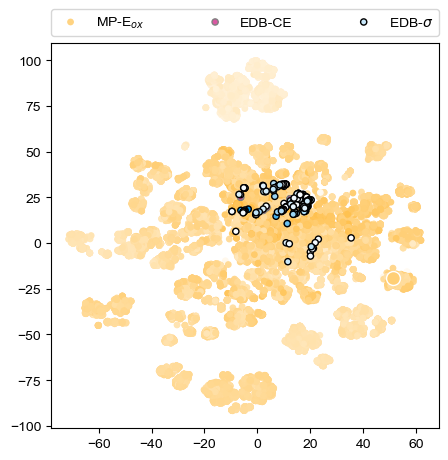

In [103]:
fig, ax = plt.subplots(figsize=(5,5))
cmap1, norm1 = create_cmap(mp_os_["mean_property_value"], 'orange')  ## orange colormap --> Oxstab
cmap2, norm2 = create_cmap(edb_cond_["mean_property_value"], (0, 0.576, 0.902))  ## blue colormap --> Conductivity
cmap3, norm3 = create_cmap(edb_ce_["mean_property_value"], (0.839, 0.286, 0.604))  ## purple colormap --> CE

# Define the coordinates of the points you want to highlight
highlight_coords = [tuple(row) for row in df_.loc[df_['smiles'].isin(['c1cc2c(cc1)C(=O)c1c(C2=O)cccc1'])][['tsne_0', 'tsne_1']].values]

mask1 = ~mp_os_[['tsne_0', 'tsne_1']].apply(tuple, 1).isin(highlight_coords)
scatter1 = ax.scatter(mp_os_[mask1]["tsne_0"], mp_os_[mask1]["tsne_1"], c=mp_os_[mask1]["mean_property_value"], s=15, cmap=cmap1, norm=norm1, label='MP-E$_{ox}$', edgecolors=None)
mask2 = mp_os_[['tsne_0', 'tsne_1']].apply(tuple, 1).isin(highlight_coords)
scatter1_ = ax.scatter(mp_os_[mask2]["tsne_0"], mp_os_[mask2]["tsne_1"], c=mp_os_[mask2]["mean_property_value"], s=100, cmap=cmap1, norm=norm1, edgecolors='white')

scatter3 = ax.scatter(edb_ce_["tsne_0"], edb_ce_["tsne_1"], c=edb_ce_["mean_property_value"], s=20, cmap=cmap3, norm=norm3, label='EDB-CE', edgecolors='grey')
scatter2 = ax.scatter(edb_cond_["tsne_0"], edb_cond_["tsne_1"], c=edb_cond_["mean_property_value"], s=20, cmap=cmap2, norm=norm2, label='EDB-$\sigma$', edgecolors='black')
# ax.vlines(x=[-13,40], ymin=-90, ymax=90, linestyles='dashed', colors='black')
# ax.hlines(y=[-13,35], xmin=-70, xmax=60, linestyles='dashed', colors='black')

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
# plt.savefig('tsne_fig1f.eps'.format(trial), dpi=300)
plt.savefig('tsne_fig1f.tiff'.format(trial), dpi=300)

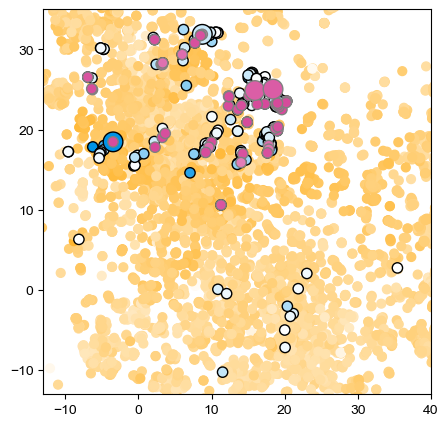

In [101]:
fig, ax = plt.subplots(figsize=(5,5))
cmap1, norm1 = create_cmap(mp_os_["mean_property_value"], 'orange')  ## orange colormap --> Oxstab
cmap2, norm2 = create_cmap(edb_cond_["mean_property_value"], (0, 0.576, 0.902))  ## blue colormap --> Conductivity
cmap3, norm3 = create_cmap(edb_ce_["mean_property_value"], (0.839, 0.286, 0.604))  ## purple colormap --> CE

# Define the coordinates of the points you want to highlight
highlight_coords_1_ = [tuple(row) for row in df_.loc[df_['smiles'].isin(['CC#N', 'CC1COC(=O)O1'])][['tsne_0', 'tsne_1']].values]
highlight_coords_2_ = [tuple(row) for row in df_.loc[df_['smiles'].isin(['COCCOC', 'COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC'])][['tsne_0', 'tsne_1']].values]

scatter1 = ax.scatter(mp_os_["tsne_0"], mp_os_["tsne_1"], c=mp_os_["mean_property_value"], s=40, cmap=cmap1, label='MP-E$_{ox}$')

# Create a mask that is True for all points except the ones at highlight_coords
mask1_1 = ~edb_cond_[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1_)
scatter1_1 = ax.scatter(edb_cond_[mask1_1]["tsne_0"], edb_cond_[mask1_1]["tsne_1"], c=edb_cond_[mask1_1]["mean_property_value"], s=55, cmap=cmap2, label='EDB-$\sigma$', edgecolors='black')

# Create a mask that is True only for the points at highlight_coords and plot these points with a different edge color
mask1_2 = edb_cond_[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1_)
scatter1_2 = ax.scatter(edb_cond_[mask1_2]["tsne_0"], edb_cond_[mask1_2]["tsne_1"], c=edb_cond_[mask1_2]["mean_property_value"], s=200, cmap=cmap2, label='EDB-$\sigma$', edgecolors='black', vmin=edb_cond_["mean_property_value"].min(), vmax=edb_cond_["mean_property_value"].max())

mask2_1 = ~edb_ce_[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2_)
scatter2_1 = ax.scatter(edb_ce_[mask2_1]["tsne_0"], edb_ce_[mask2_1]["tsne_1"], c=edb_ce_[mask2_1]["mean_property_value"], s=55, cmap=cmap3, label='EDB-CE', edgecolors='grey')

mask2_2 = edb_ce_[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2_)
scatter2_2 = ax.scatter(edb_ce_[mask2_2]["tsne_0"], edb_ce_[mask2_2]["tsne_1"], c=edb_ce_[mask2_2]["mean_property_value"], s=200, cmap=cmap3, label='EDB-CE', edgecolors='grey', vmin=edb_ce_["mean_property_value"].min(), vmax=edb_ce_["mean_property_value"].max())
# scatter3 = ax.scatter(edb_ce["tsne_0"], edb_ce["tsne_1"], c=edb_ce["mean_property_value"], s=55, cmap=cmap3, label='EDB-CE', edgecolors='grey')
plt.xlim([-13,40])
plt.ylim([-13,35])

# plt.yticks(ticks=[-20,-10,0,10,20,30,40,50], labels=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-20,-10,0,10,20,30,40,50])
# ax.xaxis.set_ticks(ticks=[-10,10,30,50])
# ax.yaxis.set_ticks(ticks=[-10,10,30,50])
# ax.set_aspect('equal')
# ax.set_yticks([-20,-10,0,10,20,30,40,50])
plt.savefig('tsne_fig1f_zoom.eps', dpi=300, bbox_inches='tight')

In [104]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_,'smiles', 'solv')

svgs_solv = [moltosvg(m).data for m in df_.solv]
smile = df_['smiles'].values.tolist()
database_class = df_['class'].values.tolist()
database = df_['database'].values.tolist()
ind = df_.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

## provided by copilot
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# color_dict = {'Aromatic':(0.839, 0.286, 0.604), 'Other':(0.984, 0.262, 0.219), 'Ether':(0.298, 0.78, 0.77),
#               'Nitriles':(0.984, 0.713, 0.305), 'Esters':(0.349,0.745,0.306), 'Carbonate':(0, 0.576, 0.902), 
#               'Sulfone':(0.95, 0.78, 0.996)}
color_dict = {'MP_oxstab':(0.984, 0.713, 0.305), 'EDB_1':(0, 0.576, 0.902), 'EDB_2':(0.839, 0.286, 0.604)}

color_dict_hex = {k: rgb_to_hex(v) for k, v in color_dict.items()}

# source = ColumnDataSource(data=dict(x=df['TSNE_0'], y=df['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df['class'].map(color_dict_hex)))
source = ColumnDataSource(data=dict(x=df_['tsne_0'], y=df_['tsne_1'], svgs_solv=svgs_solv, desc=database, smile=smile, database=database, color=df_['database'].map(color_dict_hex)))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Database: @database </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Molecular visualizations of solvent molecules (Figure 1(f))"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        legend_field='desc',
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_tnse_fig1f.html".format(trial))
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig1-data/interactive_tnse_fig1f.html'

In [89]:
df_.loc[df_['smiles'] == 'CC#N'][['tsne_0', 'tsne_1']].values[0] ## ACN

array([-3.46570545, 18.47044246])

In [90]:
df_.loc[df_['smiles'] == 'CC1COC(=O)O1'][['tsne_0', 'tsne_1']].values[0] ## PC

array([ 8.73755954, 31.87547804])

In [92]:
df_.loc[df_['smiles'] == 'COCCOC'][['tsne_0', 'tsne_1']].values[0] ## DME

array([15.92635172, 24.87164574])

In [93]:
df_.loc[df_['smiles'] == 'COCCOCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOCCOC'][['tsne_0', 'tsne_1']].values[0] ## DEG-FTriEG

array([18.41358177, 25.04524147])

In [94]:
df_.loc[df_['smiles'] == 'c1cc2c(cc1)C(=O)c1c(C2=O)cccc1'][['tsne_0', 'tsne_1']].values[0] ## anthraquinone

array([ 51.39895876, -19.16349337])